Notebook to integrate the coupled differential equations given in Goldreich and Schlichting 2014, equations 1-4

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import warnings
from matplotlib.collections import LineCollection
plt.style.use("/Library/Frameworks/Python.framework/versions/3.13/lib/python3.13/site-packages/matplotlib/style/my_style.mplstyle")

In [3]:

def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)


In [4]:
#defining the equations
#note that we are encoding [phi, n, e, pomega, lambda] as the array eqns


#equation 1:
def rhs(t, eqns, j, beta, mu_prime, tau_n, tau_e, p, nprime):
    """
    Defines the differential equations .

    Arguments:
        eqns :  vector of the state variables:
                eqns = [phi, n, e, pomega]
        t :  time
        j: order of resonance (j: (j+1))
        beta: defined as 0.8*j. from the disturbing function
        mu_prime: ratio of outer planet mass to star mass
        tau_n: migration timescale
        tau_e: damping timescale
        p: accounts for the contribution of eccentricity damping to changing the mean motion. 3 is used for this paper
        nprime: mean motion of the outer planet
    """
    consts = [j, beta, mu_prime, tau_n, tau_e, p, nprime]

    pomegadot = -consts[1]*consts[2]*eqns[1]*np.cos(eqns[0])/eqns[2] #pomega is longitude of pericenter

    phidot= (consts[0]+1)*nprime -consts[0]*eqns[1] - pomegadot #φ is a measure of the displacement of the longitude of conjunction from the inner planet’s pericenter.

    ndot = 3*consts[0]*consts[1]*consts[2]*eqns[2]*eqns[1]**2*np.sin(eqns[0])-eqns[1]/consts[3]+(consts[5]*eqns[2]**2*eqns[1]/consts[4]) #n is mean motion of pericenter.

    edot = consts[1]*consts[2]*eqns[1]*np.sin(eqns[0])-eqns[2]/consts[4] #eccentricity

    lambdadot = eqns[1]

    holder = np.zeros(5) #just doing this so everything is a float
    holder[0] = phidot
    holder[1] = ndot
    holder[2] = edot
    holder[3] = pomegadot
    holder[4] = lambdadot

    return holder



In [5]:
def muprime_min(j,beta,taue_taun):
    muprime_min = j/(np.sqrt(3)*(j+1)**(3/2)*beta)*(taue_taun)**(3/2)
    return muprime_min 

def muprime_max(j,beta,taue_taun):
    muprime_max = (j**2/(8*np.sqrt(3)*(j+1)**(3/2)*beta))*(taue_taun)**(3/2)
    return muprime_max

In [40]:
#define some initial conditions
n_initial = 1.05#somewhat offset from 1, becuase we are doing a 2:1 resoance and we have set nprime to be 1/2 (ie j=1, so (j+1)nprime = 2*nprime = 1 )
phi_initial = 0
e_initial = 0.01
pomega_initial = 0
lambda_initial = 0
#
initials=  [phi_initial, n_initial, e_initial, pomega_initial, lambda_initial]


p=3 #arbitrarily set but can be other values sometimes. Constant throughout integration.
j=1 #2:1 resonance
nprime= 0.5
tau_n=10**5/nprime#migration timescale
tau_e=tau_n*0.1758018707#eccentricity damping timescale

beta = 0.8*j #disturbing function thing

mu_prime_min = muprime_min(j,beta,tau_e/tau_n)
mu_prime_max = muprime_max(j,beta,tau_e/tau_n) #= 5*10**-5#1e-4*f**(3/2)#j/(np.sqrt(3)*(j+1)**(3/2)*beta)*(tau_e/tau_n)**3/2 # ratio of outer planet mass to star mass
mu_prime = 3e-3#mu_prime_max
#print(mu_prime)

#define the equilibirum values
e_eq = (tau_e/(3*(j+1)*tau_n))**.5
sin_phi_eq = e_eq/(beta*mu_prime*tau_e*n_initial)
#print(sin_phi_eq)
#integration time:
t_final= 1.5e6
t_initial = 0
t_span = (t_initial, t_final)
stepsize = 10 #probably want small steps
number = int(t_final/stepsize)

#where it is evaluated
t_eval=np.linspace(t_initial, t_final, num=number)

#evaluate
#atol sets number of correct decimal places
"""To achieve the desired atol set rtol such that rtol * abs(y) is always smaller than atol."""
res = solve_ivp(rhs, t_span, initials, method='RK45', t_eval=t_eval, dense_output = True, max_step = 1, rtol = 1e-6, args=(j, beta, mu_prime, tau_n, tau_e, p, nprime)) #need integrator to capture small oscillations, not smooth
print(res.status)

0.0019318886559928335
0


<>:23: SyntaxWarning: invalid escape sequence '\p'
<>:23: SyntaxWarning: invalid escape sequence '\p'
/var/folders/vj/9t__w23d0vvdk_mfg31dpn600000gn/T/ipykernel_32391/1820882467.py:23: SyntaxWarning: invalid escape sequence '\p'
  """


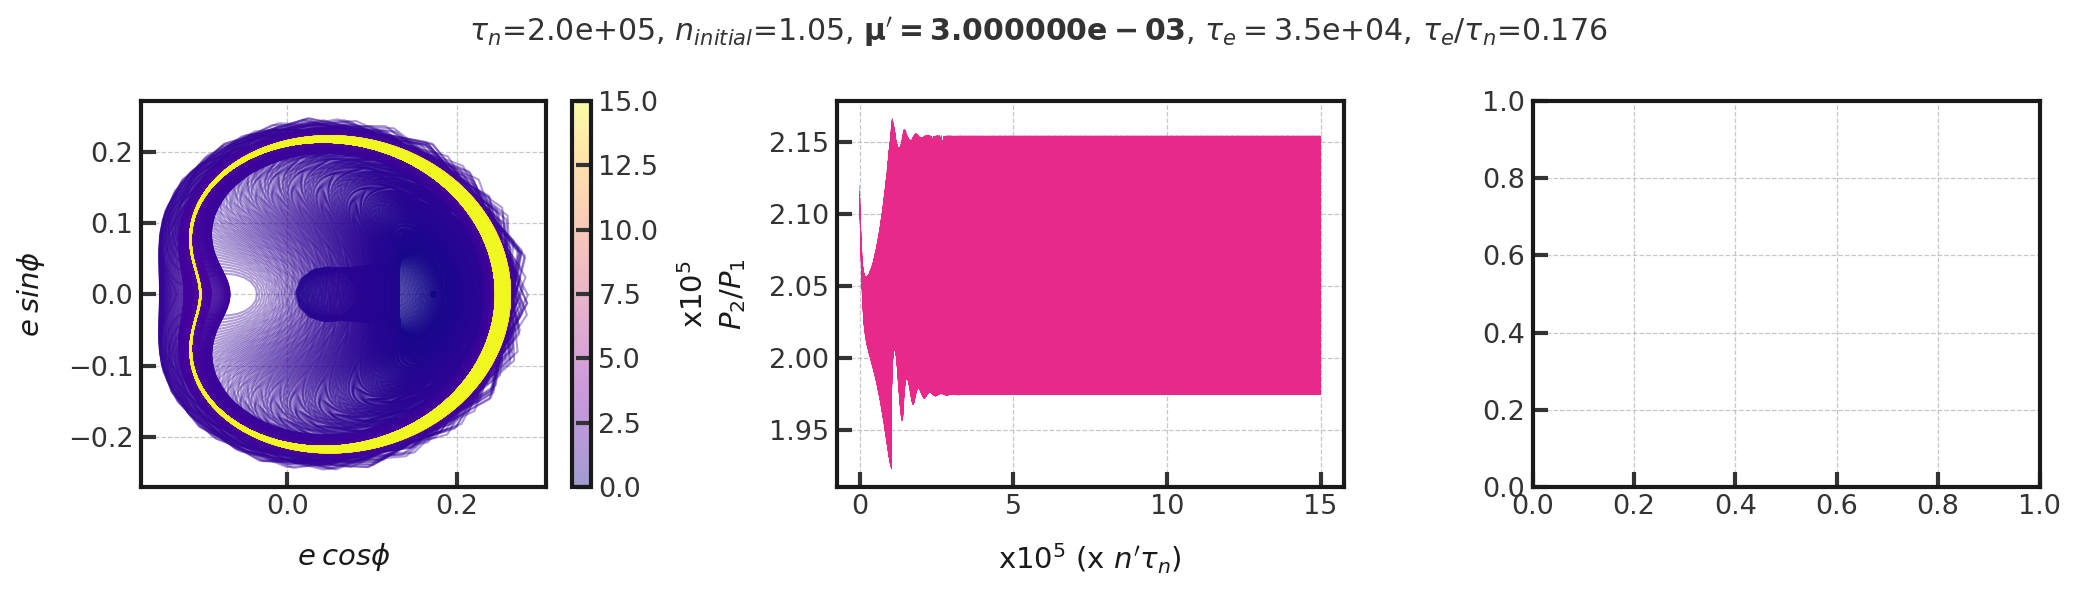

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (14,4))
fig.suptitle(r"$\tau_{n}$=%.1e, $n_{initial}$=%0.2f, $\mathbf{\mu'=%.6e}$, $\tau_{e}=$%.1e, $\tau_{e}/\tau_{n}$=%.3f" % (tau_n, n_initial, mu_prime, tau_e, tau_e/tau_n))
nth=1

color = np.linspace(0, t_final, res.t.size)
lines = colored_line(res.y[2][::nth]*np.cos(res.y[0][::nth]), res.y[2][::nth]*np.sin(res.y[0][::nth]), color/(10**5), ax1, linewidth=1, cmap="plasma",alpha = .4)
cbar = fig.colorbar(lines, label =r"x$10^{5}$")  # add a color legend



ax1.scatter(e_eq*np.cos(np.arcsin(sin_phi_eq)), e_eq*sin_phi_eq, color = "black", s = 5, label = "equilibrum")
ax1.set_xlabel(r"$e\: cos\phi$")
ax1.set_ylabel(r"$e\: sin\phi$")



ax2.plot(t_eval/(tau_n*nprime), res.y[1]/nprime, lw = .1) #P_2/P_1 = n/n'. 2 is the outer planet (not evolving)
ax2.set_xlabel(r"x$10^{%d}$ (x $n'\tau_{n})$" %(int(np.log10(tau_n))))
ax2.set_ylabel(r"$P_2/P_1$")
#ax2.set_ylim(2.014, 2.016)
#ax2.set_xlim(1, 1.05)

"""
ax3.plot(res.t/(tau_n*nprime),np.abs(np.sin(res.y[0])))
ax3.hlines((sin_phi_eq), 0, max(res.t/(10**5)), color = "black", label = r"$sin{\phi_{eq}}$")
ax3.legend(loc = "upper right")
ax3.set_xlabel(r"x$10^{%d}$ (x $n'\tau_{n})$" %(int(np.log10(tau_n))))
ax3.set_ylabel(r"$|sin{\phi}|$")
"""
fig.tight_layout()
plt.show()

Recreating figure 6:

In [56]:
def f_1(j,beta, taue_taun, muprime):
    f_1 = ((muprime*np.sqrt(3)*(j+1)**(3/2)*beta)/(j*(taue_taun)**(3/2)))**(2/3)
    return f_1

def f_2(j,beta, taue_taun, muprime):
    f_2 = ((muprime*8*np.sqrt(3)*(j+1)**(3/2)*beta)/(j**2*(taue_taun)**(3/2)))**(2/3)
    return f_2

In [19]:
def tau_ratio_1(j,beta, muprime):
    tau_ratio_1 = ((muprime*np.sqrt(3)*(j+1)**(3/2)*beta)/(j))**(2/3)
    return tau_ratio_1

def tau_ratio_2(j,beta, muprime):
    tau_ratio_2 = ((muprime*8*np.sqrt(3)*(j+1)**(3/2)*beta)/(j**2))**(2/3)
    return tau_ratio_2

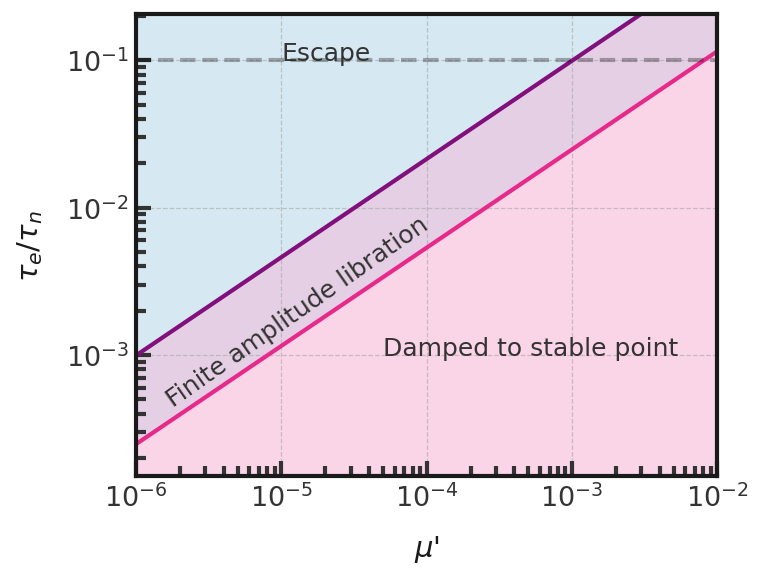

In [222]:

j = 1
beta = 0.8*j
muprime = np.linspace(1e-6, 1e-2)
plt.plot(muprime, tau_ratio_1(j,beta,muprime))
plt.fill_between( x= muprime, y1= tau_ratio_1(j,beta,muprime),alpha= 0.2)
plt.plot(muprime, tau_ratio_2(j,beta,muprime))
plt.fill_between(x= muprime, y1= tau_ratio_2(j,beta,muprime), y2 = tau_ratio_1(j,beta,muprime), alpha= 0.2)
plt.fill_between(x= muprime, y1 = 100, y2= tau_ratio_2(j,beta,muprime), alpha= 0.2)

#plt.hlines(2.5e-2, xmin=1e-6, xmax = 1e-2, color = "black", linestyles = "dashed", alpha = .3)
plt.hlines(.1, xmin=1e-6, xmax = 1e-2, color = "black", linestyles = "dashed", alpha = .3)
#plt.hlines(5e-3, xmin=1e-6, xmax = 1e-2, color = "black", linestyles = "dashed", alpha = .3)

plt.xlim(1e-6,1e-2)
plt.xscale("log")
plt.yscale("log")
plt.ylim(.00015, .205)

plt.annotate("Damped to stable point",( .00005,.001))
plt.annotate("Finite amplitude libration",( .0000015,.00045), rotation = 35)
plt.annotate("Escape",( .00001, .1))
plt.ylabel(r"$\tau_{e}/\tau_{n}$")
plt.xlabel(r"$\mu$'")
plt.show()

In [158]:
"""
for the cases shown in figure 5 of the paper:
"""
print("Planet is permanently trapped in resonance for mu'>", muprime_min(1,0.8, 1/200))
print("Planet is permanently trapped in resonance with a finite libration amplitude for",muprime_max(1,0.8,1/100),  "< mu'<", muprime_min(1,0.8, 1/100))
print("Planet is permanently trapped in resonance with a finite libration amplitude for",muprime_max(1,0.8,1/50),  "< mu'<", muprime_min(1,0.8, 1/200))

print("Planet is caught in resonance but escapes for mu'<", muprime_max(1,0.8,0.02142185440262943))
print(tau_ratio_2(1,.8,1e-4))

Planet is permanently trapped in resonance for mu'> 9.0210979560879e-05
Planet is permanently trapped in resonance with a finite libration amplitude for 3.1894397692489295e-05 < mu'< 0.00025515518153991436
Planet is permanently trapped in resonance with a finite libration amplitude for 9.0210979560879e-05 < mu'< 9.0210979560879e-05
Planet is caught in resonance but escapes for mu'< 0.00010000000000000003
0.02142185440262943


In [165]:
"""
for the case of taue/taun = 0.01 always:
"""
print("Planet is permanently trapped in resonance for mu'>", muprime_min(1,0.8, 1/100))
print("Planet is permanently trapped in resonance with a finite libration amplitude for",muprime_max(1,0.8,1/100),  "< mu'<", muprime_min(1,0.8, 1/100))
#print("Planet is permanently trapped in resonance with a finite libration amplitude for",muprime_max(1,0.8,0.0025),  "< mu'<", muprime_min(1,0.8, 0.04))

print("Planet is caught in resonance but escapes for mu'<", muprime_max(1,0.8,1/100))

Planet is permanently trapped in resonance for mu'> 0.00025515518153991436
Planet is permanently trapped in resonance with a finite libration amplitude for 3.1894397692489295e-05 < mu'< 0.00025515518153991436
Planet is caught in resonance but escapes for mu'< 3.1894397692489295e-05


In [164]:
"""

"""
print("Planet is permanently trapped in resonance for taue/taun < ", tau_ratio_1(1,0.8, 0.00025515518153991436))
print("Planet is permanently trapped in resonance with a finite libration amplitude for", tau_ratio_2(1,0.8,3.1894397692489295e-05),  "> taue/taun >", tau_ratio_1(1,0.8, 3.1894397692489295e-05))
print("Planet is permanently trapped in resonance with a finite libration amplitude for", tau_ratio_2(1,0.8,0.00025515518153991436),  "> taue/taun >", tau_ratio_1(1,0.8, 0.00025515518153991436))

print("Planet is caught in resonance but escapes for taue/taun >",  tau_ratio_2(1,0.8,3.1894397692489295e-05))

Planet is permanently trapped in resonance for taue/taun <  0.010000000000000002
Planet is permanently trapped in resonance with a finite libration amplitude for 0.010000000000000002 > taue/taun > 0.002500000000000001
Planet is permanently trapped in resonance with a finite libration amplitude for 0.04000000000000001 > taue/taun > 0.010000000000000002
Planet is caught in resonance but escapes for taue/taun > 0.010000000000000002


In [299]:
(2.5/10**6)**(3/4)

6.287167148414677e-05

In [20]:
muprime = 3e-3
t_min = tau_ratio_1(1,0.8,muprime)
t_max = tau_ratio_2(1,0.8,muprime)
print(t_min,t_max)
tau_rat_vals = np.linspace(t_min, t_max, num = 10)
print(tau_rat_vals)

0.05170643256076522 0.20682573024306086
[0.05170643 0.06894191 0.08617739 0.10341287 0.12064834 0.13788382
 0.1551193  0.17235478 0.18959025 0.20682573]


In [247]:
tau_rat_vals = np.linspace(0.002400000000000001, 0.009600000000000004, num = 10)
print(tau_rat_vals)

[0.0024 0.0032 0.004  0.0048 0.0056 0.0064 0.0072 0.008  0.0088 0.0096]
